### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
num_workers = 0
batch_size = 28
valid_size = 0.20
transform = transforms.ToTensor()

In [5]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

100.0%

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw


111.0%

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw


100.0%

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw


159.1%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw
Processing...
Done!


In [23]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split_idx = int(np.floor(num_train * valid_size))
train_idx, valid_idx = indices[split_idx:], indices[:split_idx]

In [24]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [25]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         num_workers=num_workers)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize Data

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

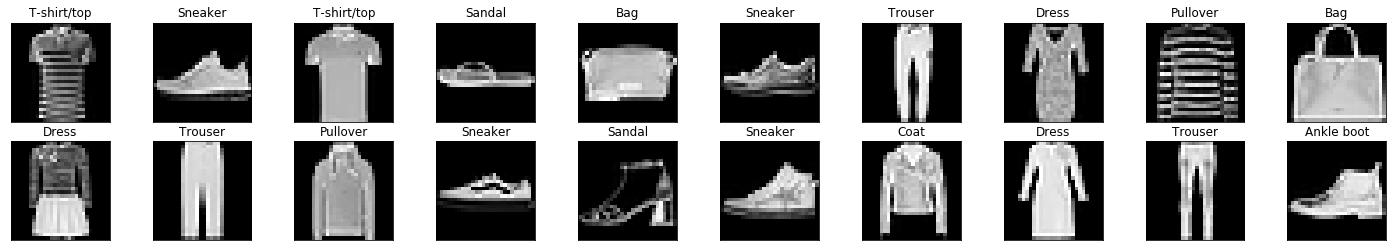

In [27]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define Model Architecture, Initialize Weights

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.25)
        
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [30]:
model_0 = Network(constant_weight=0)
model_05 = Network(constant_weight=0.5)
model_1 = Network(constant_weight=1)

### Visualize the training behavior of the various weight initializations

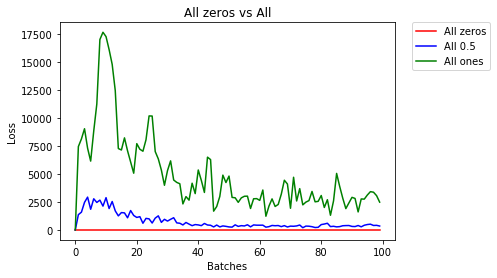

After 2 Epochs:
Validation Accuracy
   10.050% -- All zeros
   29.300% -- All 0.5
   18.700% -- All ones
Training Loss
    2.304  -- All zeros
    2.380  -- All 0.5
    1.945  -- All ones


In [34]:
import helpers #helpers.py, credit to Udacity

model_list = [(model_0, 'All zeros'),
             (model_05, 'All 0.5'),
             (model_1, 'All ones')]

helpers.compare_init_weights(model_list, 'All zeros vs All',
                            train_loader,
                            valid_loader)

### Uniform Distribution

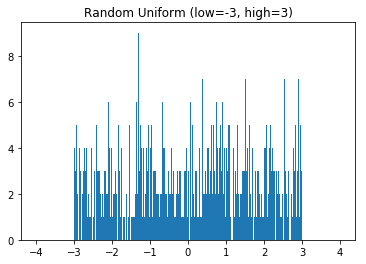

In [35]:
helpers.hist_dist('Random Uniform (low=-3, high=3)', np.random.uniform(-3, 3, [1000]))

In [37]:
# Takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        print("classname.find('Linear'): {}".format(classname.find('Linear')))
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [39]:
model_uniform = Network()
model_uniform.apply(weights_init_uniform)

classname.find('Linear'): 0
classname.find('Linear'): 0
classname.find('Linear'): 0


Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

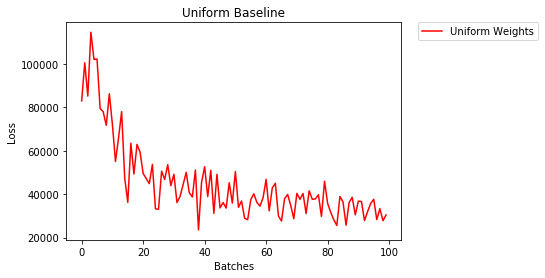

After 2 Epochs:
Validation Accuracy
   44.850% -- Uniform Weights
Training Loss
    1.754  -- Uniform Weights


In [40]:
helpers.compare_init_weights([(model_uniform, 'Uniform Weights')], 
                             'Uniform Baseline', 
                             train_loader,
                             valid_loader)

## General rule for setting weights
The general rule for setting the weights in a neural network is to set them to be close to zero without being too small. 
>Good practice is to start your weights in the range of $[-y, y]$ where $y=1/\sqrt{n}$  
($n$ is the number of inputs to a given neuron).

In [48]:
def weights_init_rule(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        #print("classname.find('Linear'): {}".format(classname.find('Linear')))
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

model_rule = Network()
model_rule.apply(weights_init_rule)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

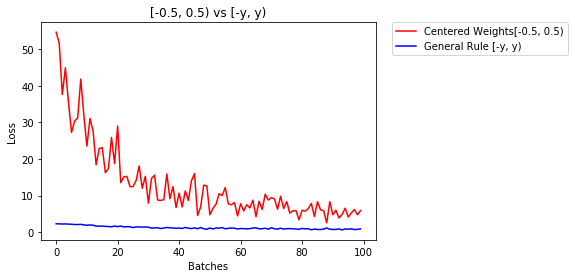

After 2 Epochs:
Validation Accuracy
   78.792% -- Centered Weights[-0.5, 0.5)
   85.642% -- General Rule [-y, y)
Training Loss
    1.516  -- Centered Weights[-0.5, 0.5)
    0.596  -- General Rule [-y, y)


In [49]:
model_list = [(model_centered, 'Centered Weights[-0.5, 0.5)'),
             (model_rule, 'General Rule [-y, y)')]

helpers.compare_init_weights(model_list,
                            '[-0.5, 0.5) vs [-y, y)',
                            train_loader,
                            valid_loader)

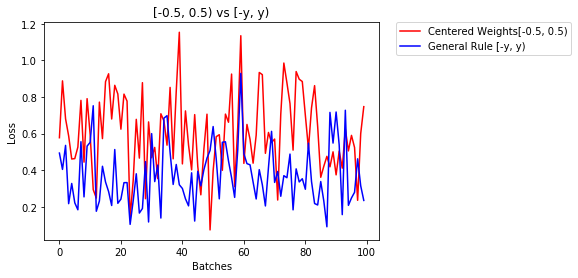

After 2 Epochs:
Validation Accuracy
   83.425% -- Centered Weights[-0.5, 0.5)
   86.508% -- General Rule [-y, y)
Training Loss
    0.153  -- Centered Weights[-0.5, 0.5)
    0.668  -- General Rule [-y, y)


In [50]:
model_list = [(model_centered, 'Centered Weights[-0.5, 0.5)'),
             (model_rule, 'General Rule [-y, y)')]

helpers.compare_init_weights(model_list,
                            '[-0.5, 0.5) vs [-y, y)',
                            train_loader,
                            valid_loader)

## Normalized Instantiation

In [56]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        #print("classname.find('Linear'): {}".format(classname.find('Linear')))
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0.0, y)
        m.bias.data.fill_(0)

model_rule = Network()
model_rule.apply(weights_init_rule)
        
model_normal = Network()
model_normal.apply(weights_init_normal)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

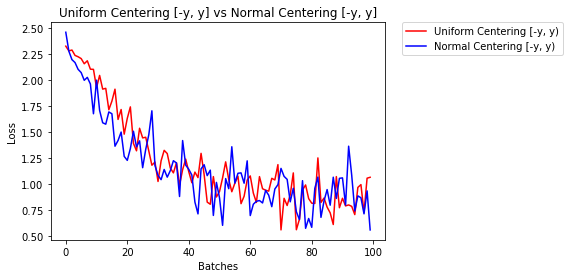

After 2 Epochs:
Validation Accuracy
   84.683% -- Uniform Centering [-y, y)
   85.317% -- Normal Centering [-y, y)
Training Loss
    0.506  -- Uniform Centering [-y, y)
    0.401  -- Normal Centering [-y, y)


In [57]:
model_list = [(model_rule, 'Uniform Centering [-y, y)'),
             (model_normal, 'Normal Centering [-y, y)')]

helpers.compare_init_weights(model_list,
                            'Uniform Centering [-y, y] vs Normal Centering [-y, y]',
                            train_loader,
                            valid_loader)